# Classfication binaire: RN de 2 couches (Tanh, Sigmoid, MSE)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from modules.linear import *
from modules.loss import *
from modules.activation import *
from tests.test_linear import *
from tests.test_activation import *


TestLinear().test_gradient(atol=1e-3, n_iter=25)
TestActivation().test_gradient_tanh(atol =1e-5, n_iter=25)
TestActivation().test_gradient_sigmoid(atol =1e-5, n_iter=25)


100%|██████████| 25/25 [00:00<00:00, 752.53it/s]


In [2]:
def train_2layers_nn(X_train, y_train, X_test, y_test, inter, n_iter = 100, lr = 1e-3):
    batch, input, output = X_train.shape[0], X_train.shape[1], y_train.shape[1] 
    print("my dim: " ,batch,input, inter, output)
    L1 = Linear(input, inter)
    Tanh1 = TanH()
    L2 = Linear(inter, output)
    Sig = Sigmoid()
    loss = MSELoss()
    loss_list = []
    test_loss_list = []
    for i in tqdm(range(n_iter)):
        z1 = L1.forward(X_train)
        z2 = Tanh1.forward(z1)
        z3 = L2.forward(z2)
        z4 = Sig.forward(z3)
        
        loss_value = loss.forward(y_train, z4)
        loss_list.append(np.sum(loss_value)/loss_value.shape[0])
        loss_test_value = loss.forward(y_test, Sig.forward(L2.forward(Tanh1.forward(L1.forward(X_test)))))
        test_loss_list.append(np.sum(loss_test_value)/loss_test_value.shape[0])
        
        loss_retro = loss.backward(y_train, z4)
        delta_sig = Sig.backward_delta(z3,loss_retro)
        if i==0:
            print(f"delta_sig shape: {delta_sig.shape}")
            print(f"z2 shape: {z2.shape}")
        delta_l2 = L2.backward_delta(z2,delta_sig)
        delta_tan1 = Tanh1.backward_delta(z1, delta_l2)
        delta_l1 = L1.backward_delta(X_train,delta_tan1)
        
        L2.backward_update_gradient(z2, delta_sig)
        L1.backward_update_gradient(X_train, delta_tan1)
        
        L2.update_parameters(gradient_step=lr)
        L1.update_parameters(gradient_step=lr)
        
        L1.zero_grad()
        L2.zero_grad()
   
    z1 = L1.forward(X_test)
    z2 = Tanh1.forward(z1)
    z3 = L2.forward(z2)
    y_pred = Sig.forward(z3)
    y_pred = (y_pred >= 0.5).astype(int)
    return loss_list, y_pred, test_loss_list

## Seaborn Data

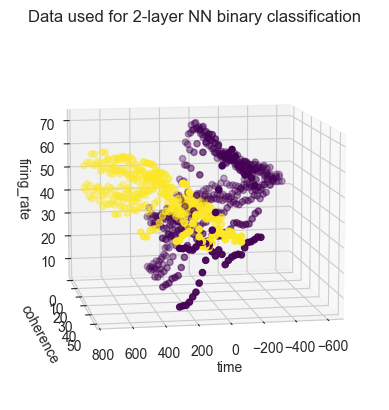

In [3]:
data = sns.load_dataset("dots")
data["y"] = (data["align"] == "dots").astype(int)
data = data.drop(columns=["align","choice"])
X = data.drop(columns="y").values
y = data["y"].values.reshape(-1, 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', elev=10, azim=80)
ax.set_title("Data used for 2-layer NN binary classification")
ax.set_xlabel('time')
ax.set_ylabel('coherence')
ax.set_zlabel('firing_rate')
scatter = ax.scatter(X[:,0], X[:,1], X[:,2], c=y.flatten(), cmap='viridis')
plt.show()

my dim:  593 3 5 1


100%|██████████| 100/100 [00:00<00:00, 2567.05it/s]

delta_sig shape: (593, 1)
z2 shape: (593, 5)


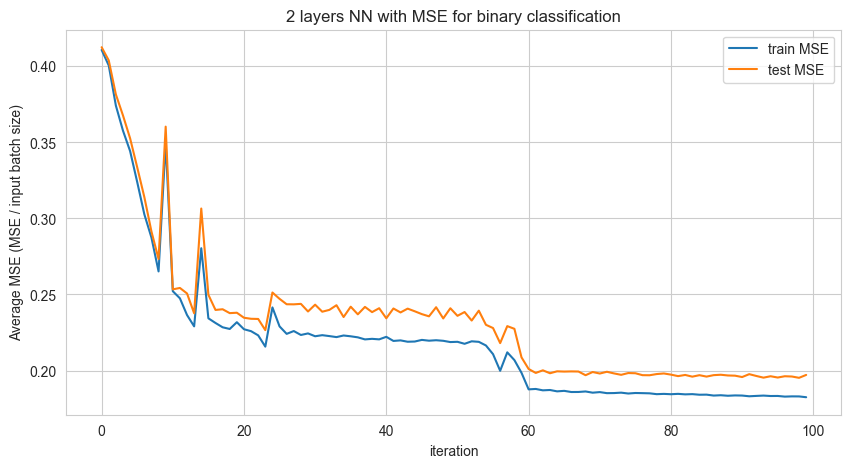

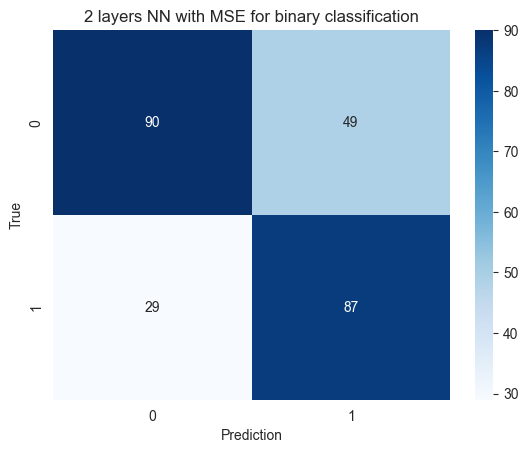

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       139
           1       0.64      0.75      0.69       116

    accuracy                           0.69       255
   macro avg       0.70      0.70      0.69       255
weighted avg       0.70      0.69      0.69       255



In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
loss_train_list , y_pred, loss_test_list= train_2layers_nn(X_train, y_train, X_test, y_test, inter=5)

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(loss_train_list)), y=loss_train_list, label="train MSE")
sns.lineplot(x=range(len(loss_train_list)), y=loss_test_list, label="test MSE")
plt.title("2 layers NN with MSE for binary classification") 
plt.xlabel("iteration")
plt.ylabel("Average MSE (MSE / input batch size)")
plt.show()

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.title("2 layers NN with MSE for binary classification")
plt.show()
print(classification_report(y_test, y_pred))